In [1]:
import cv2
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from PIL import Image
from PIL import ImageFilter
from matplotlib import animation
from PIL import ImageEnhance

from tkinter import filedialog
import tkinter as tk

import pickle

from os import sys

import matplotlib.pyplot as plt
import argparse

from statistics import mean
import os

%matplotlib inline

# for loading array 
from scipy.interpolate import interp1d
from scipy.io import loadmat
from scipy import signal as sig
import pandas as pd
import numpy as np
import mat4py
from scipy.signal import filtfilt, butter



def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise Exception("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise Exception("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise Exception("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def calculateNewSize(width,height,WishForNEwWidth):
    ratio = WishForNEwWidth/width
    Nheight = int(height * ratio)
    Nwidth = int(width * ratio)    
    return Nwidth , Nheight


def FindReferenceSystem2(video_path):
    
    HandleBEHAV = cv2.VideoCapture(video_path, 0)
    length = int(HandleBEHAV.get(cv2.CAP_PROP_FRAME_COUNT))
    
    _ , IMG1 = HandleBEHAV.read()

    linemask2= IMG1[601:602, : , 0]

    linemask2 = np.invert(linemask2)
    linemask2 = linemask2.flatten()

    smoothmask = smooth(linemask2)

    b, a = butter(8, 0.075)
    smoothfiltered = filtfilt(b, a, smoothmask)

    diffmask = np.diff(smoothfiltered,n=1)

    PeaksNO2 , values = sig.find_peaks(diffmask, height = 1)

    if np.size(PeaksNO2) == 1 : 
        Peaks3 = ((PeaksNO2 [0])  - 15)
        Peaks4 = ((PeaksNO2 [0])  + 10)
        return [Peaks3,Peaks4]

    
    
def Easyinterp(Input):
    
    if ~ len(np.shape(Input)) == 1:
        Input = np.flatten(Input)
    
    X = np.arange(0,np.size(Input),1)
    Xinterp = np.arange(0,np.size(Input),0.1)
    f2 = interp1d(X, abs(Input), kind='slinear', fill_value="extrapolate")
    raw_interp = f2(Xinterp)
    
    output = np.reshape(raw_interp, (1, np.size(raw_interp)) )
    
    return output

def diff(Input1):
    X = np.diff(abs(Input1), n=1)
    return X




def OscllObjet2 (video_path): 
    
    HandleBEHAV = cv2.VideoCapture(video_path, 0)
    length = int(HandleBEHAV.get(cv2.CAP_PROP_FRAME_COUNT))
    _ , IMG1 = HandleBEHAV.read()
    ListObj3 = []

    for framne_nb in range(length-1) :

        _ , IMG1 = HandleBEHAV.read()

        Check = np.vstack((Check , IMG1[601:602, : , 0]))

        linemask = IMG1[601:602, int(Reference_peaks2[0]):int(Reference_peaks2[1])]

        lineIMG = linemask.copy()

        linemask3 = linemask.flatten()

        smoothmask = smooth(linemask3)

        X = np.arange(0,np.size(smoothmask),1)
        Xinterp = np.arange(0,np.size(smoothmask),0.1)
        f2 = interp1d(X, abs(smoothmask), kind='slinear', fill_value="extrapolate")

        raw_interp = f2(Xinterp)

        interpol_img = np.reshape(raw_interp,(1, np.shape(raw_interp)[0]))
        interpol_img = np.vstack((interpol_img,interpol_img,interpol_img,interpol_img,interpol_img,interpol_img,interpol_img,interpol_img,interpol_img,interpol_img))

        b, a = butter(8, 0.075)
        smoothfiltered = filtfilt(b, a, raw_interp)

        diffmask = np.diff(smoothfiltered,n=1)

        DPeaks , values = sig.find_peaks(abs(diffmask), height = 0.045)
        
        

        if np.size(DPeaks) > 0:
            ListObj3.append(DPeaks[0])

        else :

            ListObj3.append(np.nan)

            
    LineFrame = Check[ 0:np.shape(Check)[0] , int(Reference_peaks2[0]):int(Reference_peaks2[1])]

    #print(np.shape(LineFrame))

    Modif = smooth(LineFrame[0,:])

    InterpFrame = Easyinterp(Modif)

    DiffFrame = np.diff(abs(InterpFrame), n=1)

    listmax = [ np.argmin(DiffFrame) ]


    for I in range(1,np.shape(LineFrame)[0],1):

        Modif = np.vstack( ( Modif, smooth(LineFrame[I,:]) ) )
        InterpFrame = np.vstack( ( InterpFrame , Easyinterp(Modif[I,:] ) ) )
        DiffFrame = np.vstack ( ( DiffFrame , diff(InterpFrame[I,:] ) ) )

        listmax.append(np.argmin(DiffFrame[I,:]))

        #if np.argmax(DiffFrame[I,:]):
        #    listmax.append(np.amax(diff(InterpFrame)))
        
    #fig = plt.figure(figsize = (25,35))
    #plt.subplot(221), plt.plot(abs(diffmask))
    #plt.subplot(222), plt.plot(ListObj3)
    #plt.subplot(223), plt.imshow(InterpFrame , 'jet')

    #plt.subplot(224), plt.imshow(DiffFrame, 'jet')
    #plt.plot(listmax,np.arange(0,np.shape(LineFrame)[0],1),'red')

    
    

[1233, 1258]
[140, 120, 140, 140, 163, 140, 165, 131, 130, 120, 151, 130, 173, 130, 120, 150, 140, 140, 151, 165, 151, 140, 140, 150, 165, 140, 165, 140, 150, 120, 140, 165, 120, 140, 150, 145, 120, 165, 140, 130, 130, 130, 150, 150, 130, 140, 120, 130, 120, 140, 150, 140, 120, 130, 151, 140, 131, 120, 120, 150, 120, 140, 140, 165, 140, 130, 140, 130, 130, 130, 120, 140, 140, 140, 130, 120, 140, 120, 150, 140, 140, 140, 138, 131, 142, 150, 140, 138, 130, 130, 140, 150, 172, 130, 130, 143, 131, 130, 143, 143, 120, 132, 120, 143, 130, 130, 140, 150, 172, 150, 130, 111, 150, 142, 150, 130, 120, 146, 150, 140, 121, 150, 141, 132, 140, 130, 150, 150, 120, 150, 142, 130, 130, 155, 146, 150, 140, 173, 143, 130, 150, 130, 155, 130, 115, 140, 142, 130, 130, 150, 120, 173, 143, 143, 143, 130, 140, 130, 130, 140, 143, 150, 165, 130, 155, 130, 120, 150, 130, 140, 130, 150, 150, 172, 143, 130, 150, 151, 130, 150, 146, 130, 140, 140, 130, 140, 120, 148, 143, 141, 120, 130, 150, 130, 140, 140, 120, 1

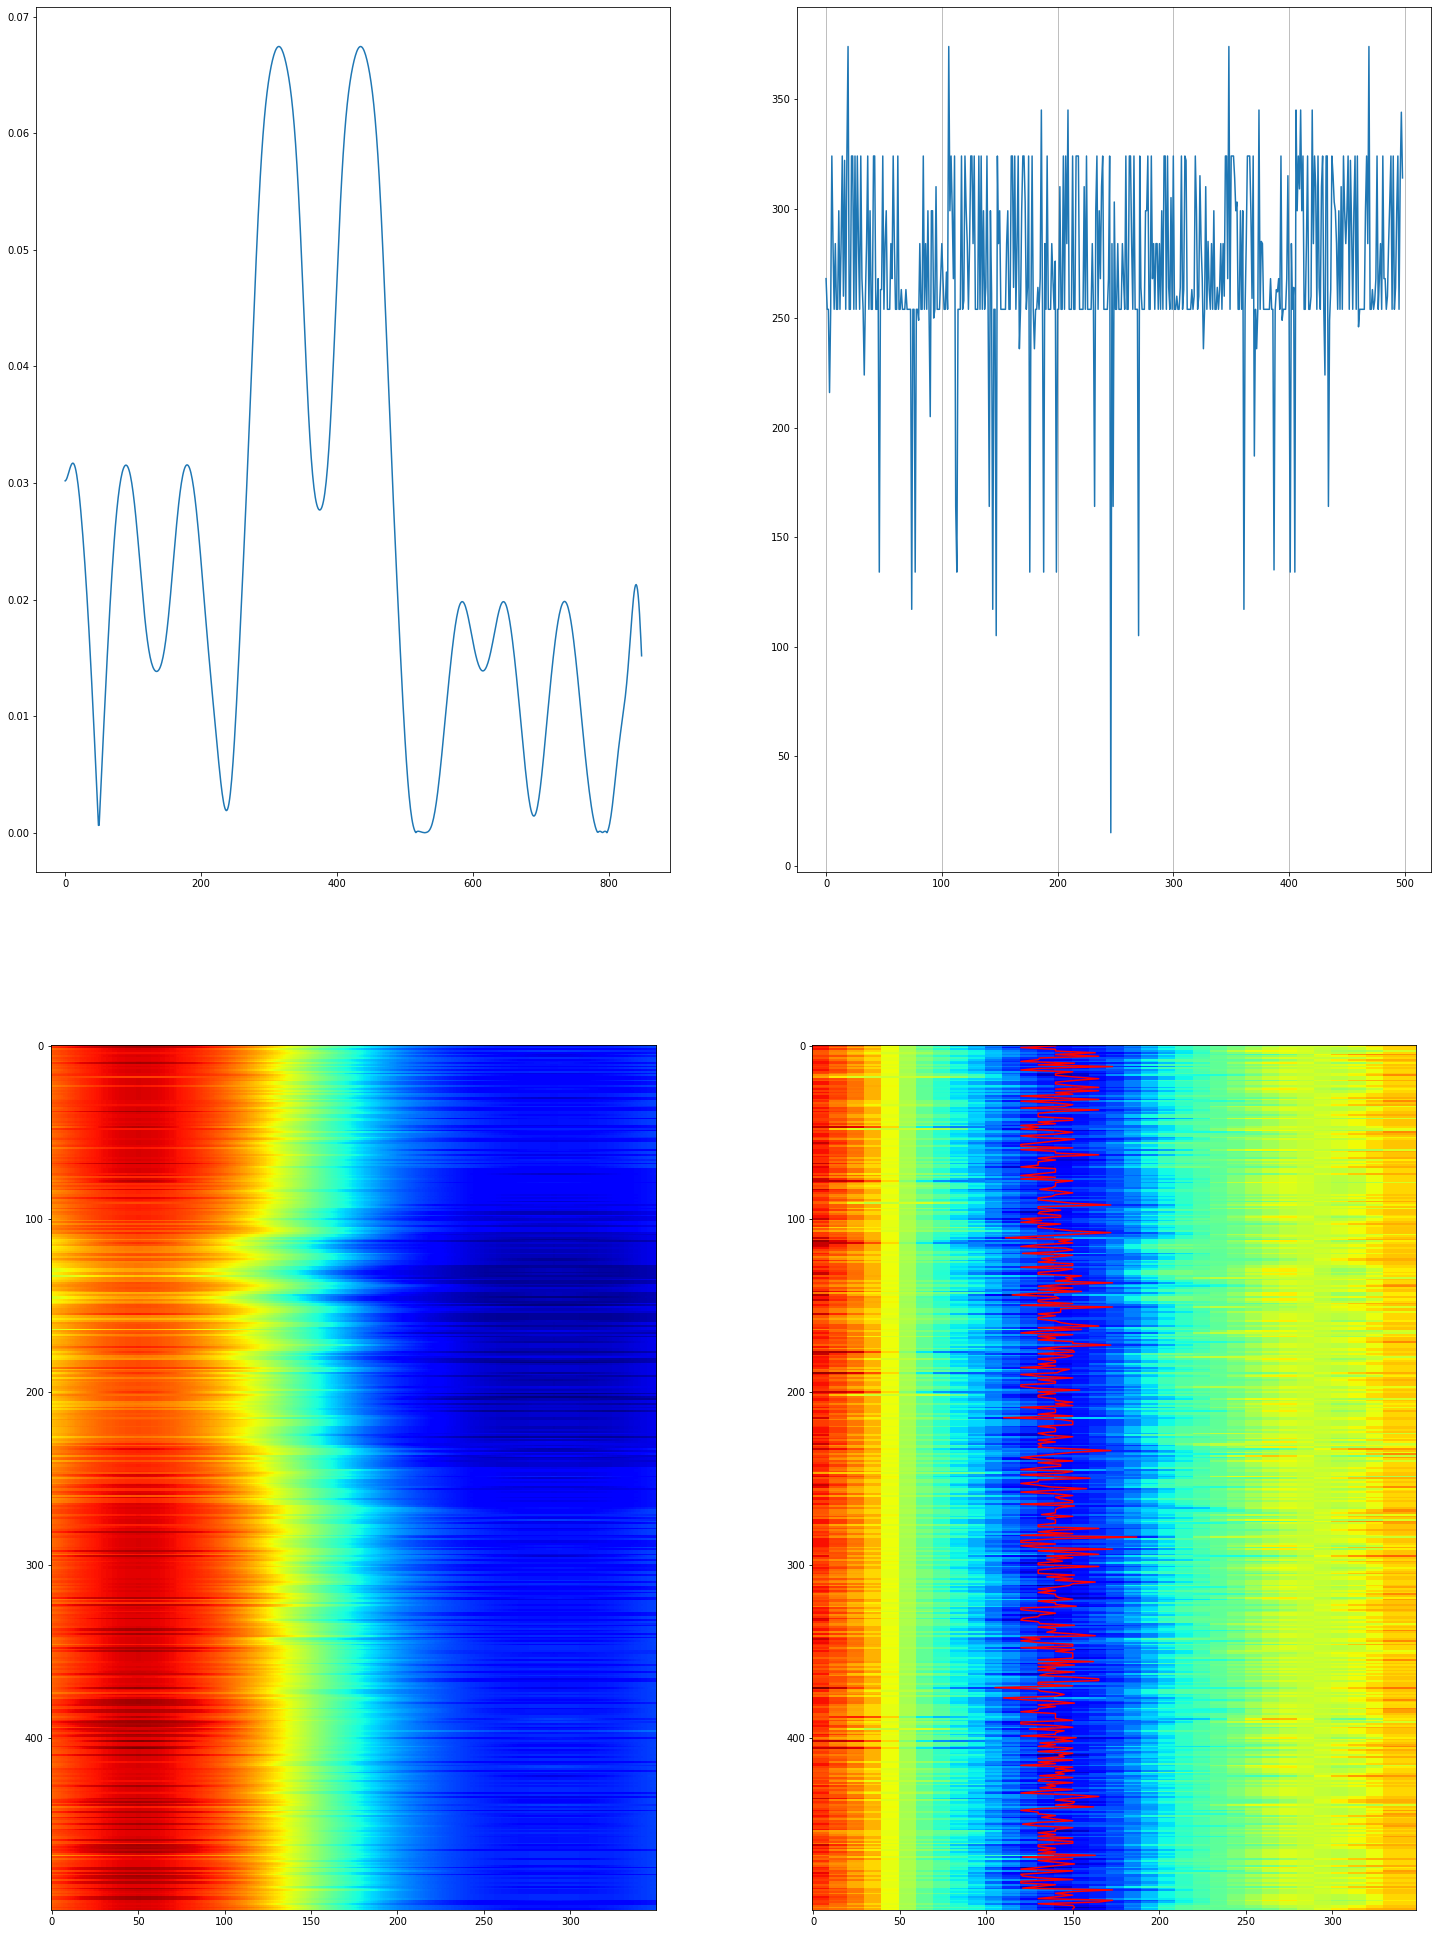

In [5]:


video_path = r"C:\Users\nkhefif\Desktop\Extraits_BHV_test_hits\Mouse25_2020-02-10T15.15.03.avi"

HandleBEHAV = cv2.VideoCapture(video_path, 0)


length = int(HandleBEHAV.get(cv2.CAP_PROP_FRAME_COUNT))


_ , IMG1 = HandleBEHAV.read()


Check = IMG1[600:601, : , 0]


#2eme objet
ListObj3 = []
ListObj4 = []

#2eme objet
Reference_peaks2 = FindReferenceSystem2(video_path)

print(Reference_peaks2)


#####2eme objet#####

for framne_nb in range(length-1) :


    _ , IMG1 = HandleBEHAV.read()
    
    Check = np.vstack((Check , IMG1[601:602, : , 0]))

    linemask = IMG1[601:602, int(Reference_peaks2[0]):int(Reference_peaks2[1])]

    lineIMG = linemask.copy()
    
    linemask3 = linemask.flatten()
    
    smoothmask = smooth(linemask3)
    
    X = np.arange(0,np.size(smoothmask),1)
    Xinterp = np.arange(0,np.size(smoothmask),0.1)
    f2 = interp1d(X, abs(smoothmask), kind='slinear', fill_value="extrapolate")
    
    raw_interp = f2(Xinterp)
    
    interpol_img = np.reshape(raw_interp,(1, np.shape(raw_interp)[0]))
    interpol_img = np.vstack((interpol_img,interpol_img,interpol_img,interpol_img,interpol_img,interpol_img,interpol_img,interpol_img,interpol_img,interpol_img))

    b, a = butter(8, 0.075)
    smoothfiltered = filtfilt(b, a, raw_interp)

    diffmask = np.diff(smoothfiltered,n=1)
   
    DPeaks , values = sig.find_peaks(abs(diffmask), height = 0.045)

    if np.size(DPeaks) > 0:
        ListObj3.append(DPeaks[0])
            
    else :
       
        ListObj3.append(np.nan)

#print(DPeaks)
#print(ListObj3)



Listpeaks2 = []
Listframe2 = []    

SD = np.nanstd(ListObj3)
MeanPeaks = np.nanmean(ListObj3)



        
LineFrame = Check[ 0:np.shape(Check)[0] , int(Reference_peaks2[0]):int(Reference_peaks2[1])]
        
#print(np.shape(LineFrame))

Modif = smooth(LineFrame[0,:])

InterpFrame = Easyinterp(Modif)

DiffFrame = np.diff(abs(InterpFrame), n=1)

listmax = [ np.argmin(DiffFrame) ]


for I in range(1,np.shape(LineFrame)[0],1):
    
    Modif = np.vstack( ( Modif, smooth(LineFrame[I,:]) ) )
    InterpFrame = np.vstack( ( InterpFrame , Easyinterp(Modif[I,:] ) ) )
    DiffFrame = np.vstack ( ( DiffFrame , diff(InterpFrame[I,:] ) ) )
    
    listmax.append(np.argmin(DiffFrame[I,:]))
    
    #if np.argmax(DiffFrame[I,:]):
    #    listmax.append(np.amax(diff(InterpFrame)))
        
print(listmax)

print(np.shape(Check))
        
        

fig = plt.figure(figsize = (25,35))


plt.subplot(221), plt.plot(abs(diffmask))

#plt.subplot(222), plt.plot(abs(smooth(np.asarray(ListObj1)-MeanPeaks)))

plt.subplot(222), plt.plot(ListObj3)
#plt.subplot(222), plt.plot(smoothmask)
#plt.subplot(222), plt.plot(smoothmask)

#plt.xticks(range(0, 540, 20))
#plt.yticks(range(200, 500, 30))
plt.grid(axis="x")



#plt.subplot(223), plt.imshow(Check, 'jet')

#plt.scatter( int(Reference_peaks2[0]) , 20, s = 1, c = 'red')
#plt.scatter( int(Reference_peaks2[1]) , 20, s = 1,  c = 'red')

#plt.plot( [int(Reference_peaks2[0]),int(Reference_peaks2[0])] , [0,np.shape(Check)[0]], linewidth = 1,  c = 'red')
#plt.plot( [int(Reference_peaks2[1]),int(Reference_peaks2[1])] , [0,np.shape(Check)[0]], linewidth = 1,  c = 'red')

#plt.subplot(224), plt.imshow(Check[   int(Reference_peaks2[1]):int(Reference_peaks2[0])    ,   0:np.shape(Check)[0]   ] , 'jet')
#plt.subplot(224), plt.imshow(Check[ 0:np.shape(Check)[0] , int(Reference_peaks2[1]):int(Reference_peaks2[0])] , 'jet')
plt.subplot(223), plt.imshow(InterpFrame , 'jet')

plt.subplot(224), plt.imshow(DiffFrame, 'jet')
plt.plot(listmax,np.arange(0,np.shape(LineFrame)[0],1),'red')


#plt.subplot(224), plt.plot(Listframe2, Listpeaks2, 'o')
#plt.subplot(224), plt.plot(raw_interp)

#plt.xticks(range(0, 500, 20))
#plt.yticks(range(200, 700, 10))

        
        
        
        
        
#fig = plt.figure(figsize = (25,35)

#plt.subplot(221), plt.plot(smoothmask)

#plt.subplot(222), plt.plot(smoothfiltered)

#plt.subplot(223), plt.plot(abs(diffmask))

#plt.subplot(224), plt.imshow(lineIMG, 'gray')

#plt.subplot(224), plt.plot(interpolatedmask)

#plt.subplot(223), plt.imshow(lineIMG, 'gray')

#plt.subplot(224), plt.plot(Listframe, Listpeaks, 'o')